### Plot vertical profiles in the limbs
(not averaged over the opening angle)

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.calc import meridional_mean
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import add_custom_legend

In [3]:
from util_commons import GASES, PLANETS, ROSE_SUITES

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
iris.FUTURE.datum_support = True
rcParams["mathtext.default"] = "regular"

In [5]:
# Parameters
planet = "wasp96b"
path_to_project = Path.home() / "projects" / planet
tK = "tK_6"  # weak diffusion
t0 = -20  # last 200 days
tgt_plevs = np.logspace(7, 2, 65)
tgt_lons = [91.25, 271.25]
interp_args = ([("longitude", tgt_lons)], iris.analysis.Linear())
chem_names = ["CH4", "CO", "CO2", "H2O", "HCN", "NH3"]

In [6]:
vrbls = {}
for exp in ["equilibrium", "kinetics"]:
    vrbls[exp] = {}
    for mdh in tqdm(["mdh_0", "mdh_1"]):
        vrbls[exp][mdh] = {}
        # Find data
        fpath = ROSE_SUITES[planet][exp][mdh][tK]["dir_for_data"] / "merged"
        fname = f"{ROSE_SUITES[planet][exp][mdh][tK]['rose_suite']}.nc"
        # Interpolate temperature to pressure levels
        pres = iris.load_cube(fpath / fname, um.pres)[t0:, ...].collapsed(
            "time", iris.analysis.MEAN
        )
        temp = (iris.load_cube(fpath / fname, um.temp)[t0:, ...]).collapsed(
            "time", iris.analysis.MEAN
        )
        temp_plevs = interp_cube_from_height_to_pressure_levels(temp, pres, tgt_plevs)
        # Average over the respective limb with weighting
        temp_plevs_limb_west_mean_wghtd = meridional_mean(
            temp_plevs.extract(iris.Constraint(longitude=91.25))
        )
        temp_plevs_limb_east_mean_wghtd = meridional_mean(
            temp_plevs.extract(iris.Constraint(longitude=271.25))
        )
        pres_coord = temp_plevs.coord("air_pressure").points
        # Same for chemical species
        chem_plevs = iris.cube.CubeList()
        chem_plevs_limb_west_mean_wghtd_cl = iris.cube.CubeList()
        chem_plevs_limb_east_mean_wghtd_cl = iris.cube.CubeList()
        for chem_name in chem_names:
            cube = (
                iris.load_cube(fpath / fname, f"{chem_name} mole fraction")[t0:, ...]
            ).collapsed("time", iris.analysis.MEAN)
            cube_plevs = interp_cube_from_height_to_pressure_levels(cube, pres, tgt_plevs)
            chem_plevs.append(cube_plevs)
            chem_plevs_limb_west_mean_wghtd = meridional_mean(
                cube_plevs.extract(iris.Constraint(longitude=91.25))
            )
            chem_plevs_limb_east_mean_wghtd = meridional_mean(
                cube_plevs.extract(iris.Constraint(longitude=271.25))
            )
            chem_plevs_limb_west_mean_wghtd_cl.append(chem_plevs_limb_west_mean_wghtd)
            chem_plevs_limb_east_mean_wghtd_cl.append(chem_plevs_limb_east_mean_wghtd)
        # Assemble data
        vrbls[exp][mdh] = {
            "temp_plevs": temp_plevs,
            "chem_plevs": chem_plevs,
            "temp_plevs_limb_west_mean_wghtd": temp_plevs_limb_west_mean_wghtd,
            "temp_plevs_limb_east_mean_wghtd": temp_plevs_limb_east_mean_wghtd,
            "chem_plevs_limb_west_mean_wghtd_cl": chem_plevs_limb_west_mean_wghtd_cl,
            "chem_plevs_limb_east_mean_wghtd_cl": chem_plevs_limb_east_mean_wghtd_cl,
        }

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# Legends
exp_dict = {
    "Equilibrium": {"color": "k", "ls": "dashed", "lw": 1},
    "Kinetics": {"color": "k", "ls": "solid", "lw": 1},
}
mdh_dict = {
    "[M/H]=0": {"color": "k", "ls": "solid", "lw": 2},
    "[M/H]=1": {"color": "k", "ls": "solid", "lw": 1},
}
limb_mean_dict = {
    "Morning": {"color": "C0", "ls": "solid", "lw": 2},
    "Evening": {"color": "C1", "ls": "solid", "lw": 2},
}
limb_all_dict = {
    "Morning": {"color": "C0", "ls": "solid", "lw": 1, "alpha": 0.5},
    "Evening": {"color": "C1", "ls": "solid", "lw": 1, "alpha": 0.5},
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


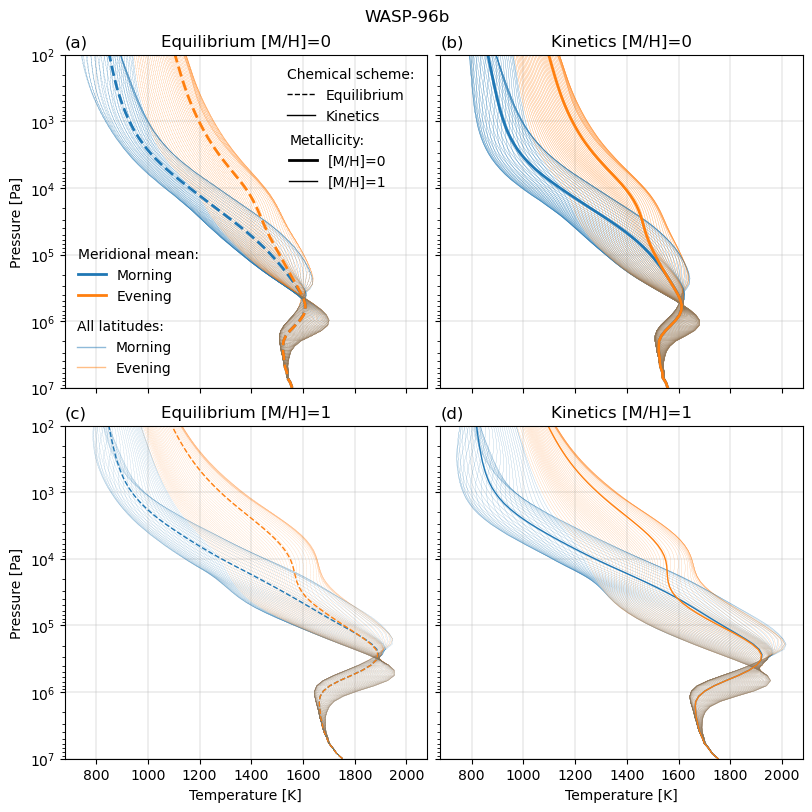

In [8]:
# Plot pressure-temperature profiles at limbs
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True
)
for exp, exp_ls, axcol in zip(["equilibrium", "kinetics"], ["dashed", "solid"], axs.T):
    for mdh, mdh_lw, ax in zip(["mdh_0", "mdh_1"], [2, 1], axcol):
        ax.set_title(f"{exp.capitalize()} [M/H]={mdh[-1]}")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Pressure [Pa]")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Temperature [K]")
        # Add all latitudes
        for lat in temp_plevs.coord("latitude").points:
            p_west_all = (
                vrbls[exp][mdh]["temp_plevs"]
                .extract(iris.Constraint(latitude=lat, longitude=91.25))
                .data
            )
            p_east_all = (
                vrbls[exp][mdh]["temp_plevs"]
                .extract(iris.Constraint(latitude=lat, longitude=271.25))
                .data
            )
            ax.plot(p_west_all, pres_coord, ls=exp_ls, lw=mdh_lw * 0.1, color="C0", alpha=0.5)
            ax.plot(p_east_all, pres_coord, ls=exp_ls, lw=mdh_lw * 0.1, color="C1", alpha=0.5)
        # Add meridional means
        p_west_mean = vrbls[exp][mdh]["temp_plevs_limb_west_mean_wghtd"].data
        p_east_mean = vrbls[exp][mdh]["temp_plevs_limb_east_mean_wghtd"].data
        ax.plot(p_west_mean, pres_coord, ls=exp_ls, lw=mdh_lw, color="C0")
        ax.plot(p_east_mean, pres_coord, ls=exp_ls, lw=mdh_lw, color="C1")
for iax in axs.flatten():
    iax.set_yscale("log")
    iax.set_ylim(1e7, 1e2)
    iax.grid(lw=0.3)
axs[0, 0].set_title("(a)", loc="left")
axs[0, 1].set_title("(b)", loc="left")
axs[1, 0].set_title("(c)", loc="left")
axs[1, 1].set_title("(d)", loc="left")
add_custom_legend(
    axs[0, 0],
    exp_dict,
    frameon=False,
    title="Chemical scheme:",
    alignment="left",
    loc="upper right",
)
add_custom_legend(
    axs[0, 0],
    mdh_dict,
    frameon=False,
    title="Metallicity:",
    alignment="left",
    bbox_to_anchor=(0.585, 0.56),
)
add_custom_legend(
    axs[0, 0],
    limb_mean_dict,
    frameon=False,
    title="Meridional mean:",
    alignment="left",
    bbox_to_anchor=(0.405, 0.46),
)
add_custom_legend(
    axs[0, 0],
    limb_all_dict,
    frameon=False,
    title="All latitudes:",
    alignment="left",
    loc="lower left",
)
axs[0, 0].legend(frameon=False)
fig.suptitle(f'{PLANETS[planet]["tex"]}')
figname_png = f"{planet}_vp_pres_temp_limbs.png"
figname_pdf = f"{planet}_vp_pres_temp_limbs.pdf"
fig.savefig(path_to_project / "circulation" / "vertical_profiles_pres_temp" / figname_png)
fig.savefig(
    path_to_project / "circulation" / "vertical_profiles_pres_temp" / figname_pdf,
    format="pdf",
    bbox_inches="tight",
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


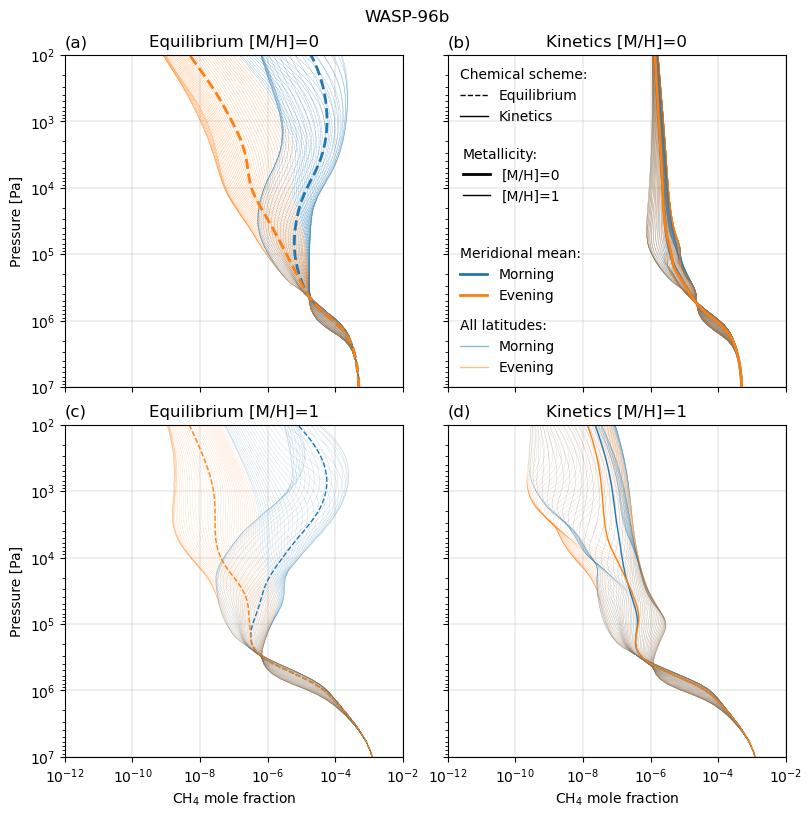

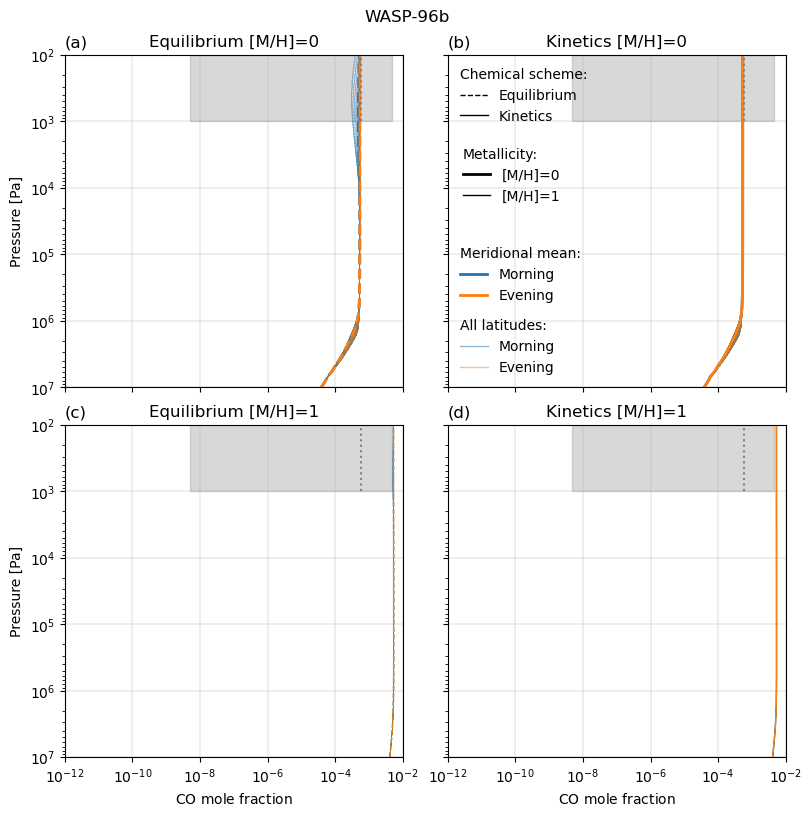

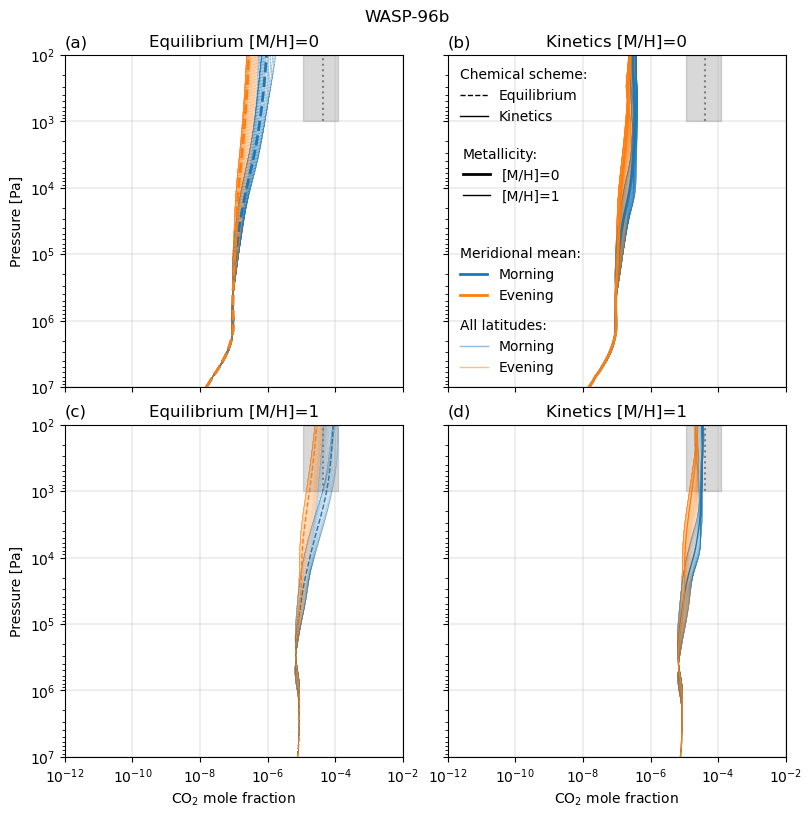

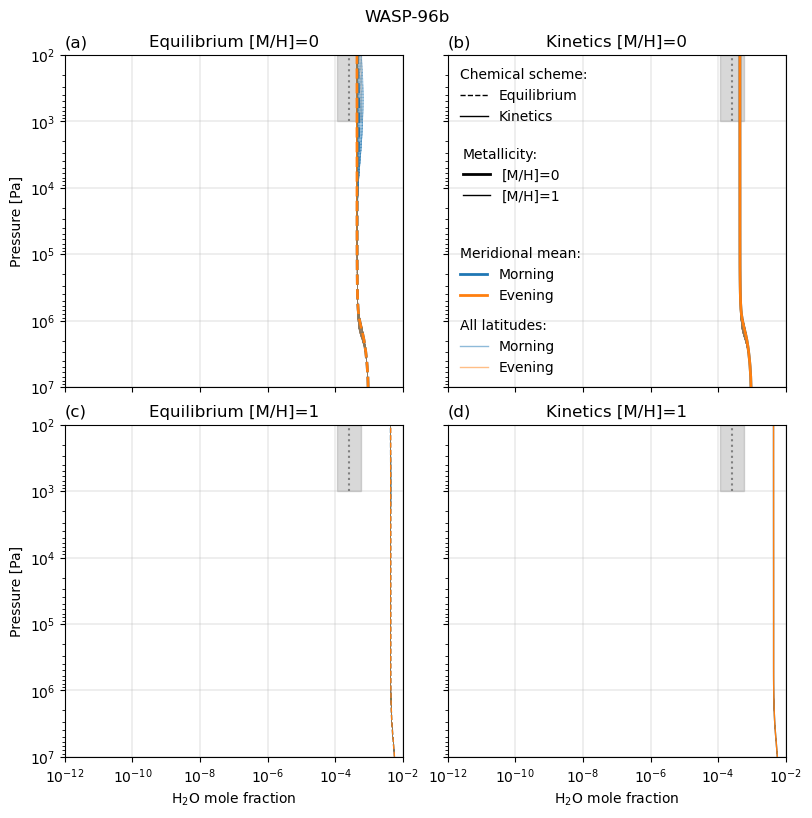

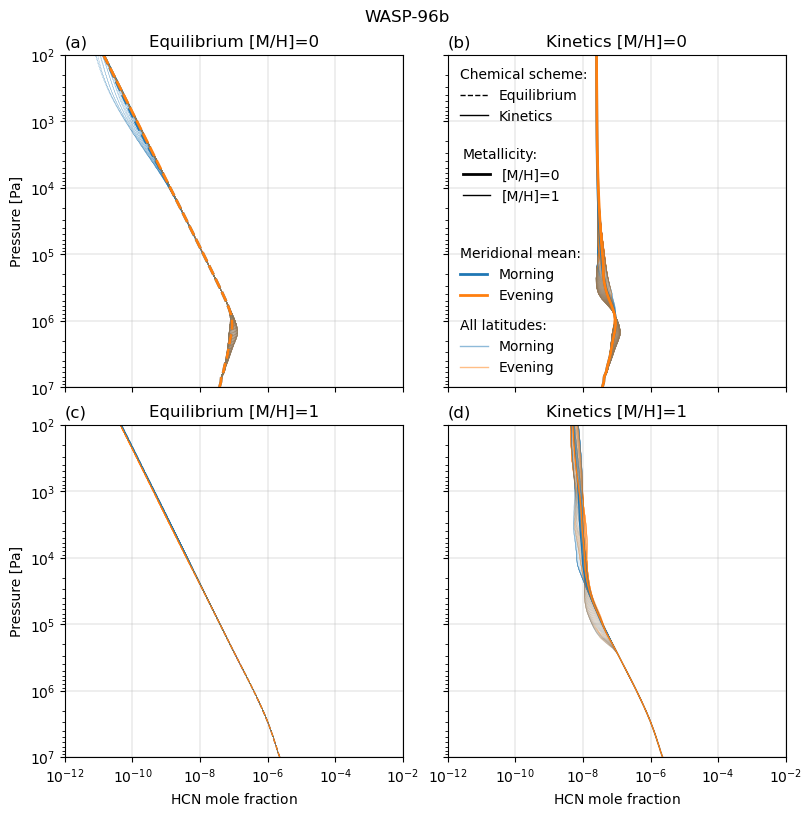

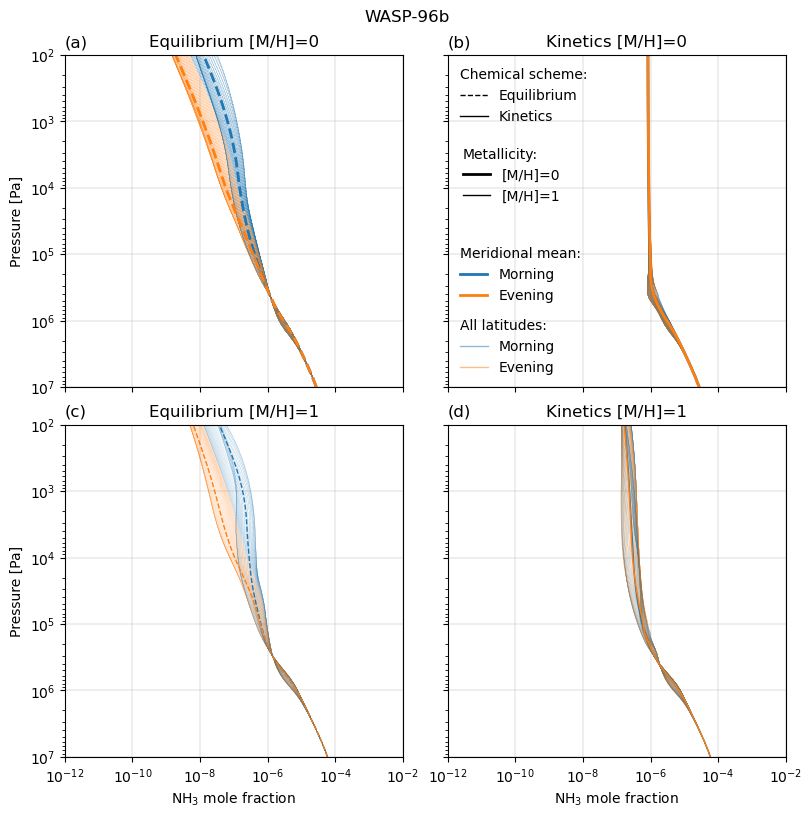

In [10]:
# Plot pressure-species profiles at limbs
for n, chem_name in enumerate(chem_names):
    fig, axs = plt.subplots(
        nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True
    )
    for exp, exp_ls, axcol in zip(["equilibrium", "kinetics"], ["dashed", "solid"], axs.T):
        for mdh, mdh_lw, ax in zip(["mdh_0", "mdh_1"], [2, 1], axcol):
            ax.set_title(f"{exp.capitalize()} [M/H]={mdh[-1]}")
            if ax.get_subplotspec().is_first_col():
                ax.set_ylabel("Pressure [Pa]")
            if ax.get_subplotspec().is_last_row():
                ax.set_xlabel(f"{GASES[chem_name]['tex']} mole fraction")
            for lat in temp_plevs.coord("latitude").points:
                p_west_all = (
                    vrbls[exp][mdh]["chem_plevs"]
                    .extract_cube(f"{chem_name} mole fraction")
                    .extract(iris.Constraint(latitude=lat, longitude=91.25))
                    .data
                )
                p_east_all = (
                    vrbls[exp][mdh]["chem_plevs"]
                    .extract_cube(f"{chem_name} mole fraction")
                    .extract(iris.Constraint(latitude=lat, longitude=271.25))
                    .data
                )
                ax.plot(p_west_all, pres_coord, ls=exp_ls, lw=mdh_lw * 0.1, color="C0", alpha=0.5)
                ax.plot(p_east_all, pres_coord, ls=exp_ls, lw=mdh_lw * 0.1, color="C1", alpha=0.5)
            p_west_mean = vrbls[exp][mdh]["chem_plevs_limb_west_mean_wghtd_cl"][n].data
            p_east_mean = vrbls[exp][mdh]["chem_plevs_limb_east_mean_wghtd_cl"][n].data
            ax.plot(p_west_mean, pres_coord, ls=exp_ls, lw=mdh_lw, color="C0")
            ax.plot(p_east_mean, pres_coord, ls=exp_ls, lw=mdh_lw, color="C1")
    for iax in axs.flatten():
        iax.set_xscale("log")
        iax.set_yscale("log")
        iax.set_xlim(1e-12, 1e-2)
        iax.set_ylim(1e7, 1e2)
        iax.grid(lw=0.3)
        # Add retrieval constrains from Taylor et al. (2023)
        if chem_name == "H2O":
            iax.axvline(x=pow(10, -3.59), ymin=0.8, ymax=1, color="grey", ls="dotted")
            iax.axvspan(
                pow(10, -3.59 - 0.35),
                pow(10, -3.59 + 0.35),
                ymin=0.8,
                ymax=1,
                alpha=0.3,
                color="grey",
            )
        if chem_name == "CO":
            iax.axvline(x=pow(10, -3.25), ymin=0.8, ymax=1, color="grey", ls="dotted")
            iax.axvspan(
                pow(10, -3.25 - 5.06),
                pow(10, -3.25 + 0.91),
                ymin=0.8,
                ymax=1,
                alpha=0.3,
                color="grey",
            )
        if chem_name == "CO2":
            iax.axvline(x=pow(10, -4.38), ymin=0.8, ymax=1, color="grey", ls="dotted")
            iax.axvspan(
                pow(10, -4.38 - 0.57),
                pow(10, -4.38 + 0.47),
                ymin=0.8,
                ymax=1,
                alpha=0.3,
                color="grey",
            )
    axs[0, 0].set_title("(a)", loc="left")
    axs[0, 1].set_title("(b)", loc="left")
    axs[1, 0].set_title("(c)", loc="left")
    axs[1, 1].set_title("(d)", loc="left")
    add_custom_legend(
        axs[0, 1],
        exp_dict,
        frameon=False,
        title="Chemical scheme:",
        alignment="left",
        loc="upper left",
    )
    add_custom_legend(
        axs[0, 1],
        mdh_dict,
        frameon=False,
        title="Metallicity:",
        alignment="left",
        bbox_to_anchor=(0.37, 0.76),
    )
    add_custom_legend(
        axs[0, 1],
        limb_mean_dict,
        frameon=False,
        title="Meridional mean:",
        alignment="left",
        bbox_to_anchor=(0.43, 0.46),
    )
    add_custom_legend(
        axs[0, 1],
        limb_all_dict,
        frameon=False,
        title="All latitudes:",
        alignment="left",
        loc="lower left",
    )
    axs[0, 1].legend(frameon=False)
    fig.suptitle(f'{PLANETS[planet]["tex"]}')
    figname_png = f"{planet}_vp_pres_{chem_name.lower()}_limbs.png"
    figname_pdf = f"{planet}_vp_pres_{chem_name.lower()}_limbs.pdf"
    fig.savefig(path_to_project / "chemistry" / "vertical_profiles_pres_chem" / figname_png)
    fig.savefig(
        path_to_project / "chemistry" / "vertical_profiles_pres_chem" / figname_pdf,
        format="pdf",
        bbox_inches="tight",
    )